In this notebook we evaluate the explainability of two models : KAN and Random Forest, on the Default Credit dataset. To do this, we'll be using two popular methods, SHAP and PFI.

In [1]:
!pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-n5v7atmg
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-n5v7atmg
  Resolved https://github.com/KindXiaoming/pykan.git to commit d51e849bc7e95bc9733d4259e61192ba9bffa697
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78190 sha256=8db7f9ee7c93619c03c11798c31305dd84a901e3947f02e66d6463d74dedd251
  Stored in directory: /tmp/pip-ephem-wheel-cache-t0g72_zz/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


Import packages

In [2]:
import torch
from kan import KAN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
import shap

Data Analysis and Cleaning

In [3]:
df = pd.read_csv("/content/default_credit.csv")

In [4]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_PAYEMENT
0,20000.0,Female,University,Married,24,Pay_delay>=1,Pay_delay>=1,Pay_duly,Pay_duly,Pay_duly,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,Female,University,Single,26,Pay_duly,Pay_delay>=1,Pay_duly,Pay_duly,Pay_duly,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,Female,University,Single,34,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,Female,University,Married,37,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,Male,University,Married,57,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,Male,High_school,Married,39,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,Male,High_school,Single,43,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,Male,University,Single,37,Pay_delay>=1,Pay_delay>=1,Pay_delay>=1,Pay_duly,Pay_duly,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,Male,High_school,Married,41,Pay_delay>=1,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [5]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 LIMIT_BAL            0
SEX                  0
EDUCATION           14
MARRIAGE             0
AGE                  0
PAY_0                0
PAY_2                0
PAY_3                0
PAY_4                0
PAY_5                0
PAY_6                0
BILL_AMT1            0
BILL_AMT2            0
BILL_AMT3            0
BILL_AMT4            0
BILL_AMT5            0
BILL_AMT6            0
PAY_AMT1             0
PAY_AMT2             0
PAY_AMT3             0
PAY_AMT4             0
PAY_AMT5             0
PAY_AMT6             0
DEFAULT_PAYEMENT     0
dtype: int64


In [6]:
df.dropna(inplace=True)  # Drop rows with missing values

In [9]:
distinct_values = df['MARRIAGE'].unique()
print("Distinct values in 'MARRIAGE':", distinct_values)

Distinct values in 'MARRIAGE': ['Married' 'Single' 'Others']


In [8]:
# One-hot encoding categorical columns 1/0
columns_encode = ['SEX', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
encoded_data = pd.get_dummies(df[columns_encode], prefix=columns_encode)
encoded_data = encoded_data.astype(int)

In [10]:
# Concatenate the one-hot encoded columns with the original DataFrame
df.drop(columns_encode, axis=1, inplace=True)
df = pd.concat([df, encoded_data], axis=1)

In [11]:
# Encoding categorical features
categorical_cols = ['EDUCATION', 'MARRIAGE']

# Label Encoding for categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [12]:
df

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,...,PAY_2_Pay_delay>=1,PAY_2_Pay_duly,PAY_3_Pay_delay>=1,PAY_3_Pay_duly,PAY_4_Pay_delay>=1,PAY_4_Pay_duly,PAY_5_Pay_delay>=1,PAY_5_Pay_duly,PAY_6_Pay_delay>=1,PAY_6_Pay_duly
0,20000.0,3,0,24,3913.0,3102.0,689.0,0.0,0.0,0.0,...,1,0,0,1,0,1,0,1,0,1
1,120000.0,3,2,26,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,...,1,0,0,1,0,1,0,1,1,0
2,90000.0,3,2,34,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,...,0,1,0,1,0,1,0,1,0,1
3,50000.0,3,0,37,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,...,0,1,0,1,0,1,0,1,0,1
4,50000.0,3,0,57,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,...,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,0,39,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,...,0,1,0,1,0,1,0,1,0,1
29996,150000.0,1,2,43,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,...,0,1,0,1,0,1,0,1,0,1
29997,30000.0,3,2,37,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,...,1,0,1,0,0,1,0,1,0,1
29998,80000.0,1,0,41,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,...,0,1,0,1,0,1,0,1,0,1


In [13]:
#normalizing data
scaler = MinMaxScaler()
columns_to_normalize = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [14]:
# Prepare input features and labels
X = df.drop('DEFAULT_PAYEMENT', axis=1)
y = df['DEFAULT_PAYEMENT']

# Ensure X and y do not contain NaNs
X.dropna(inplace=True)
y.dropna(inplace=True)
y = y[X.index]  # Align y with the remaining X

In [15]:
# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [16]:
print(X_test.shape)

(4498, 30)


In [17]:
# Drop NaNs in X_train, X_val, and X_test
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train.dropna(inplace=True)
y_val.dropna(inplace=True)
y_test.dropna(inplace=True)

In [18]:
# transforming the data
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [19]:
# creating the dataset
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

Random Forest Classifier

In [ ]:
""""
#GridSearch to find the best parameters
# Simplified parameter grid
param_grid = {
    "max_depth": [None, 10, 12, 15],
    "min_samples_leaf": [1, 2, 4],
    "n_estimators": [100, 200, 300],
    "max_samples": [0.8, 0.9, 0.99]
}

# Initialize the base Random Forest model
rf = RandomForestClassifier(random_state=1)

# Set up GridSearchCV with fewer iterations
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
# Fit the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)""""

SyntaxError: unterminated string literal (detected at line 20) (3543624047.py, line 20)

Random Forest Model

In [20]:
# the best model from GridSearchCV
rf_model = RandomForestClassifier(
    max_depth=10,
    max_samples=0.9,
    min_samples_leaf=4,
    n_estimators=100,
    random_state=1
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions
train_preds_rf = rf_model.predict(X_train)
val_preds_rf = rf_model.predict(X_val)
test_preds_rf = rf_model.predict(X_test)


In [21]:
#Evaluating the model
# Accuracy
print("Train Accuracy:", accuracy_score(y_train, train_preds_rf))
print("Validation Accuracy:", accuracy_score(y_val, val_preds_rf))
print("Test Accuracy:", accuracy_score(y_test, test_preds_rf))

# Precision, rappel, F1-score
print("Train Precision:", precision_score(y_train, train_preds_rf))
print("Train Recall:", recall_score(y_train, train_preds_rf))
print("Train F1-Score:", f1_score(y_train, train_preds_rf))

Train Accuracy: 0.8467841829442592
Validation Accuracy: 0.8134726545131169
Test Accuracy: 0.8072476656291685
Train Precision: 0.7703731911652704
Train Recall: 0.43636755823986195
Train F1-Score: 0.5571467915174882


PFI for Random Forest

Ordered Feature Importance (PFI):
               Feature  Importance   Std Dev
18  PAY_0_Pay_delay>=1    0.011249  0.000759
19      PAY_0_Pay_duly    0.011072  0.000807
4            BILL_AMT1    0.003557  0.001413
22  PAY_3_Pay_delay>=1    0.002557  0.000528
23      PAY_3_Pay_duly    0.001890  0.000500
8            BILL_AMT5    0.001756  0.001122
9            BILL_AMT6    0.001112  0.000964
15            PAY_AMT6    0.000845  0.001075
25      PAY_4_Pay_duly    0.000800  0.000447
26  PAY_5_Pay_delay>=1    0.000667  0.000588
2             MARRIAGE    0.000600  0.000621
21      PAY_2_Pay_duly    0.000556  0.001227
0            LIMIT_BAL    0.000534  0.000960
5            BILL_AMT2    0.000422  0.001100
7            BILL_AMT4    0.000400  0.000611
27      PAY_5_Pay_duly    0.000400  0.000495
11            PAY_AMT2    0.000200  0.000886
3                  AGE    0.000178  0.000611
16          SEX_Female    0.000089  0.000573
10            PAY_AMT1    0.000044  0.001430
17            SEX_Mal

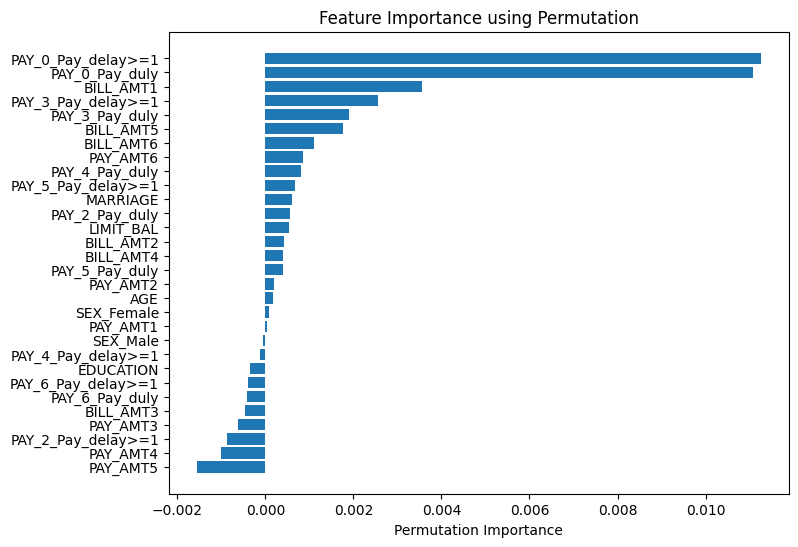

In [22]:
# Calculate Permutation Feature Importance (PFI)
pfi_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Create a DataFrame to store the importance results
pfi_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean,
    'Std Dev': pfi_result.importances_std
})

# Sort the features by importance
pfi_importances_sorted = pfi_importances.sort_values(by='Importance', ascending=False)

# Display the ordered feature importances
print("Ordered Feature Importance (PFI):")
print(pfi_importances_sorted)

# Plot the feature importance in descending order
plt.figure(figsize=(8, 6))
plt.barh(pfi_importances_sorted['Feature'], pfi_importances_sorted['Importance'])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance using Permutation")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

SHAP for Random Forest

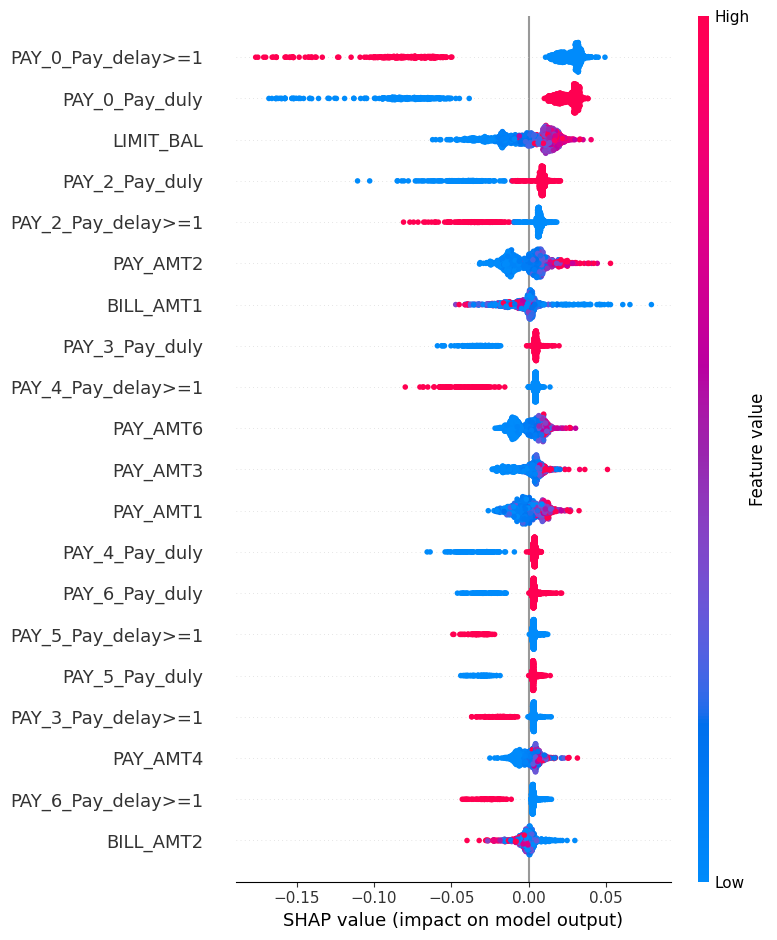

In [23]:
# Initialize SHAP explainer for the Random Forest model
X_test_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values_rf = explainer(X_test_sample)
shap.summary_plot(shap_values_rf[:,:,0], X_test_sample)

# Calculate the mean absolute SHAP value for each feature across all samples for class 0
shap_importances = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Importance': np.mean(np.abs(shap_values_rf[:,:,0].values), axis=0)
})
shap_importances_sorted = shap_importances.sort_values(by='Importance', ascending=False)

Agreement metric

In [24]:
# Function to measure greement for the top k features using Jaccard Index
def agreement_metric(top_k_shap, top_k_pfi):
    set_shap = set(top_k_shap)
    set_pfi = set(top_k_pfi)

    intersection = len(set_shap.intersection(set_pfi))
    union = len(set_shap.union(set_pfi))

    score = intersection / union if union != 0 else 0
    return score


In [25]:
# Define k the number of top features to compare
k = 4

# Extract top k features
top_k_shap = shap_importances_sorted['Feature'][:k]
top_k_pfi = pfi_importances_sorted['Feature'][:k]

score = agreement_metric(top_k_shap, top_k_pfi)
print(f"Agreement metric for the top {k} features using Random Forest: {score:.4f}")

Agreement metric for the top 4 features using Random Forest: 0.3333


KAN Model

In [ ]:
# Create the KAN model
model = KAN(width=[30, 10, 1], grid=5, k=3, seed=0)  # one hidden layer with 10 neurons

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
from sklearn.metrics import mean_squared_error
results = model.fit(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=50, loss_fn=torch.nn.BCEWithLogitsLoss() #Binary crossentropy loss
)

| train_loss: 6.60e-01 | test_loss: 6.61e-01 | reg: 0.00e+00 | :  98%|▉| 49/50 [13:08<00:15, 15.52s/

In [ ]:

# Predictions of train, val, and test datasets
test_preds = model.forward(test_input).detach()
train_preds = model.forward(train_input).detach()
val_preds = model.forward(val_input).detach()

# Sigmoid to get probabilities
test_probs = torch.sigmoid(test_preds)
train_probs = torch.sigmoid(train_preds)
val_probs = torch.sigmoid(val_preds)

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
test_preds_binary = (test_probs >= 0.5).int()
train_preds_binary = (train_probs >= 0.5).int()
val_preds_binary = (val_probs >= 0.5).int()

# Evaluate metrics for training data
train_labels = train_label.numpy()
train_preds_binary = train_preds_binary.numpy()
val_labels = val_label.numpy()
val_preds_binary = val_preds_binary.numpy()
test_labels = test_label.numpy()
test_preds_binary = test_preds_binary.numpy()

print("Train Accuracy:", accuracy_score(train_labels, train_preds_binary))
print("Train Precision:", precision_score(train_labels, train_preds_binary))
print("Val Accuracy:", accuracy_score(val_labels, val_preds_binary))
print("Val Precision:", precision_score(val_labels, val_preds_binary))
print("Test Accuracy:", accuracy_score(test_labels, test_preds_binary))
print("Test Precision:", precision_score(test_labels, test_preds_binary))



Train Accuracy: 0.8166269652215341
Train Precision: 0.6484345529988683
Val Accuracy: 0.8081369497554469
Val Precision: 0.6184448462929476
Test Accuracy: 0.8079146287238773
Test Precision: 0.6334586466165414


PFI for KAN

              Features  Importances
19      PAY_0_Pay_duly     0.055912
18  PAY_0_Pay_delay>=1     0.023988
0            LIMIT_BAL     0.007214
4            BILL_AMT1     0.007108
21      PAY_2_Pay_duly     0.006047
20  PAY_2_Pay_delay>=1     0.004028
5            BILL_AMT2     0.003960
15            PAY_AMT6     0.002821
10            PAY_AMT1     0.002732
23      PAY_3_Pay_duly     0.002190
17            SEX_Male     0.001332
1            EDUCATION     0.001298
7            BILL_AMT4     0.001003
13            PAY_AMT4     0.000909
9            BILL_AMT6     0.000843
11            PAY_AMT2     0.000674
2             MARRIAGE     0.000607
12            PAY_AMT3     0.000480
27      PAY_5_Pay_duly     0.000427
26  PAY_5_Pay_delay>=1     0.000291
16          SEX_Female     0.000236
22  PAY_3_Pay_delay>=1     0.000176
28  PAY_6_Pay_delay>=1     0.000024
3                  AGE    -0.000084
6            BILL_AMT3    -0.000185
14            PAY_AMT5    -0.000482
25      PAY_4_Pay_duly    -0

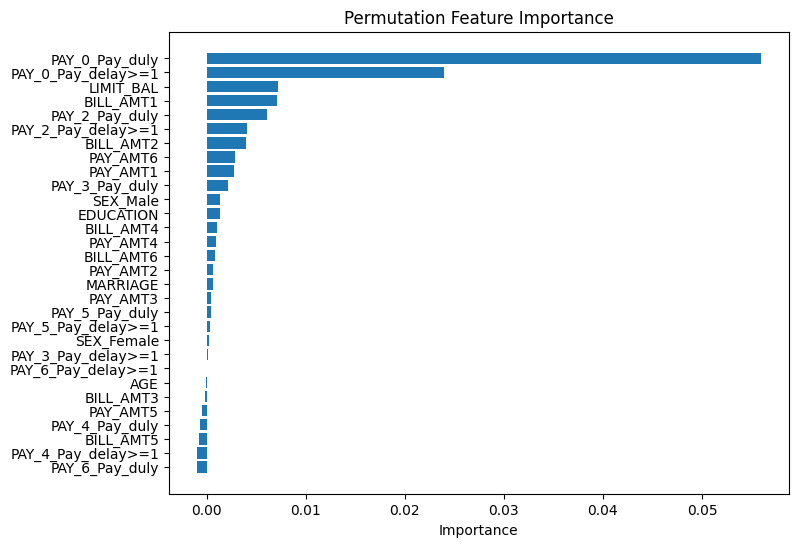

In [ ]:

# Function to evaluate model performance using accuracy
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32))
        probs = torch.sigmoid(logits).numpy()
        predictions = (probs >= 0.5).astype(int)
    return accuracy_score(y, predictions)

# Function to calculate permutation feature importance (PFI)
def permutation_importance(model, X, y, metric=evaluate_model, n_repeats=100):
    baseline_score = metric(model, X, y)
    importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(model, X_permuted, y)
            scores.append(score)
        importances[i] = baseline_score - np.mean(scores)

    return importances


# Convert validation data to numpy arrays
X_val_tensor = X_val.to_numpy()
y_val_tensor = y_val.to_numpy()

# Calculate feature importances
importances_kan = permutation_importance(model, X_val_tensor, y_val_tensor)

# Create DataFrame with feature importances
importance_df = pd.DataFrame({
    'Features': X_val.columns,
    'Importances': importances_kan
}).sort_values(by='Importances', ascending=False)

print(importance_df)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Features'], importance_df['Importances'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


SHAP for KAN

In [ ]:

# Define a prediction function that returns probabilities
def predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        # Get logits from the model and apply sigmoid to get probabilities
        logits = model(data_tensor)
        probs = torch.sigmoid(logits).numpy()
    return probs

# Sampling data
X_train_subset = X_train.sample(500, random_state=42).to_numpy()
X_test_subset = X_test.sample(500, random_state=42).to_numpy()

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(predict, X_train_subset)

# Compute SHAP values for the test set subset
shap_values = explainer.shap_values(X_test_subset)

if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Select the SHAP values for class 1 (positive class)


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  output_range_spline = torch.std(postacts_numerical, dim

ValueError: Must pass 2-d input. shape=(500, 30, 1)

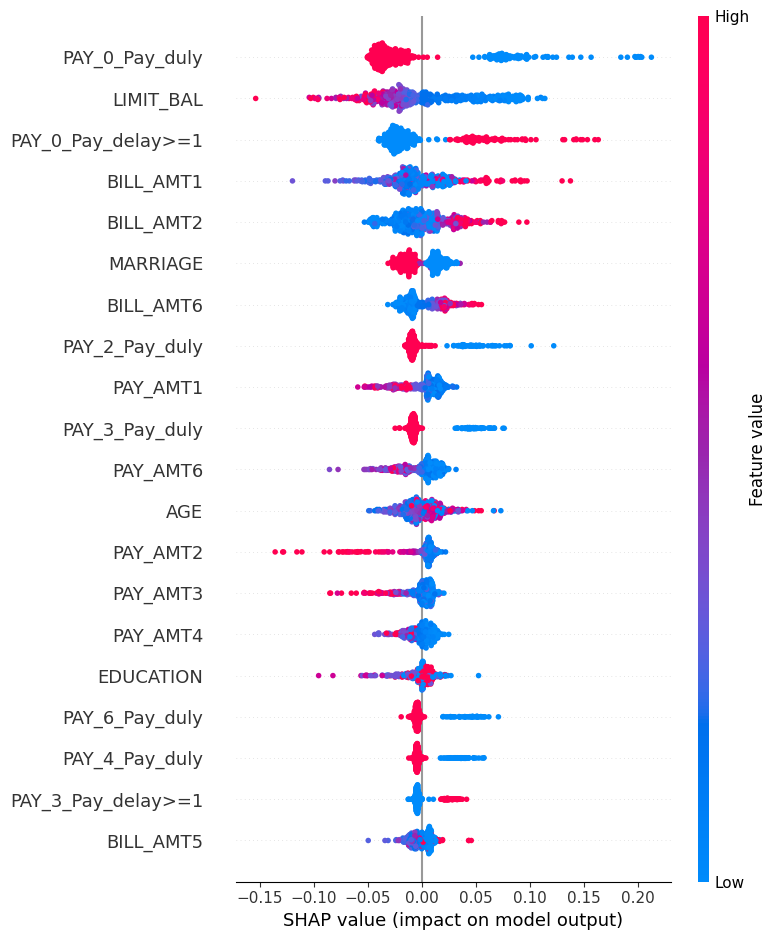

In [ ]:
# Plot the SHAP summary plot to visualize feature importance
shap_values = np.squeeze(shap_values)

# Convert the SHAP values into a DataFrame
shap_df_kan = pd.DataFrame(shap_values, columns=X_test.columns)

shap.summary_plot(shap_values, X_test_subset, feature_names=X_test.columns)


Agreement metric

In [26]:
#Creating lists of top k features of shap and pfi for KAN
k = 4
top_k_pfi_features_kan = ['PAY_0_Pay_duly', 'PAY_0_Pay_delay>=1', 'LIMIT_BAL', 'BILL_AMT1']
top_k_shap_features_kan = ['PAY_0_Pay_duly', 'LIMIT_BAL', 'PAY_0_Pay_delay>=1', 'BILL_AMT1']

score_kan = agreement_metric(top_k_shap_features_kan, top_k_pfi_features_kan)

# Print the result
print(f"Agreement metric for the top {k} features using KAN: {score_kan:.4f}")

Agreement metric for the top 4 features using KAN: 1.0000
